In [21]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [22]:
import torch
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
from scipy.integrate import quad_vec
from pyDOE import lhs
import time
import warnings
warnings.filterwarnings('ignore')

np.random.seed(1234)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [23]:
# Heston特征函数（Schoutens稳定版本）
def Heston_char_func(u, T, v0, r, kappa, theta, vola_sigma, rho):
    sigma = vola_sigma
    xi = kappa - sigma * rho * u
    d = np.sqrt(xi**2 + sigma**2 * (u**2 + 1j*u))
    g1 = (xi + d) / (xi - d)
    g2 = 1 / g1
    cf = np.exp(
        1j * u * r * T
        + (kappa * theta / sigma**2) * ( (xi - d)*T - 2*np.log( (1 - g2*np.exp(-d*T)) / (1 - g2) ) )
        + (v0/sigma**2) * (xi - d) * (1 - np.exp(-d*T)) / (1 - g2*np.exp(-d*T))
    )
    return cf

# Heston解析解
def heston_price(S, K, T, r, v0, kappa, theta, vola_sigma, rho):
    def P_j(j):
        def integrand(u):
            phi_j = np.exp(
                (1j * u * np.log(S)) + (A_j(u) + B_j(u) * v0)
            )
            weight = np.exp(-0.01 * u)  # 衰减因子提高稳定性
            return np.real((np.exp(-1j * u * np.log(K)) * phi_j * weight) / (1j * u))
        integral = quad_vec(integrand, 0, 100)[0]  # 限制积分上限，使用矢量化积分
        return 0.5 + (1 / np.pi) * integral
    
    def A_j(u):
        xi = kappa - vola_sigma * rho * u * 1j
        d = np.sqrt(xi**2 + vola_sigma**2 * (u**2 + 1j * u))
        g2 = (xi - d) / (xi + d)
        return ((kappa * theta) / vola_sigma**2) * (
            (xi - d) * T - 2 * np.log((1 - g2 * np.exp(-d * T)) / (1 - g2))
        )
    
    def B_j(u):
        xi = kappa - vola_sigma * rho * u * 1j
        d = np.sqrt(xi**2 + vola_sigma**2 * (u**2 + 1j * u))
        g2 = (xi - d) / (xi + d)
        return (xi - d) * (1 - np.exp(-d * T)) / (vola_sigma**2 * (1 - g2 * np.exp(-d * T)))
    
    P1, P2 = P_j(1), P_j(2)
    return S * np.exp(-r * T) * P1 - K * np.exp(-r * T) * P2

In [24]:
# 深度神经网络类
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        self.depth = len(layers) - 1
        self.activation = torch.nn.Tanh()
        layer_list = []
        for i in range(self.depth - 1):
            layer_list.append(('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1])))
            layer_list.append(('activation_%d' % i, self.activation))
        layer_list.append(('layer_%d' % (self.depth-1), torch.nn.Linear(layers[-2], layers[-1])))
        self.layers = torch.nn.Sequential(OrderedDict(layer_list))
    
    def forward(self, x):
        return self.layers(x)

In [25]:
# 物理引导神经网络类
class PhysicsInformedNN():
    def __init__(self, X_u, u, X_f, layers, lb, ub, r, kappa, theta, vola_sigma, rho):
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        self.S_u = torch.tensor(X_u[:,0:1], requires_grad=True).float().to(device)
        self.v_u = torch.tensor(X_u[:,1:2], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:,2:3], requires_grad=True).float().to(device)
        self.S_f = torch.tensor(X_f[:,0:1], requires_grad=True).float().to(device)
        self.v_f = torch.tensor(X_f[:,1:2], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:,2:3], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        
        self.r = r
        self.kappa = kappa
        self.theta = theta
        self.vola_sigma = vola_sigma
        self.rho = rho
        
        self.dnn = DNN(layers).to(device)
        
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=5000, 
            max_eval=5000,
            history_size=100,
            tolerance_change=1e-9,
            line_search_fn="strong_wolfe"
        )
        
        self.iter = 0
        self.loss_history = []

    def net_u(self, S, v, t):
        x = torch.cat([S, v, t], dim=1)
        xu = 2.0 * (x - self.lb) / (self.ub - self.lb) - 1.0  # 归一化输入
        return self.dnn(xu)
    
    def net_f(self, S, v, t):
        u = self.net_u(S, v, t)
        
        u_t = torch.autograd.grad(u, t, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_S = torch.autograd.grad(u, S, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_v = torch.autograd.grad(u, v, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        
        u_SS = torch.autograd.grad(u_S, S, torch.ones_like(u_S), retain_graph=True, create_graph=True)[0]
        u_Sv = torch.autograd.grad(u_S, v, torch.ones_like(u_S), retain_graph=True, create_graph=True)[0]
        u_vv = torch.autograd.grad(u_v, v, torch.ones_like(u_v), retain_graph=True, create_graph=True)[0]
        
        f = u_t + self.r *S*u_S + self.kappa*(self.theta - v)*u_v + \
            0.5*v*S**2*u_SS + self.rho*self.vola_sigma*v*S*u_Sv + \
            0.5*(self.vola_sigma**2)*v*u_vv - self.r*u
        return f

    def loss_func(self):
        self.optimizer.zero_grad()
        
        u_pred = self.net_u(self.S_u, self.v_u, self.t_u)
        f_pred = self.net_f(self.S_f, self.v_f, self.t_f)
        
        loss_u = torch.mean((self.u - u_pred)**2)
        loss_f = torch.mean(f_pred**2)
        
        loss = loss_u + loss_f
        loss.backward()
        
        self.iter += 1
        if self.iter % 100 == 0:
            print(f'Iter {self.iter}, Loss: {loss.item():.3e}, Loss_u: {loss_u.item():.3e}, Loss_f: {loss_f.item():.3e}')
        self.loss_history.append(loss.item())
        return loss

    def train(self):
        self.dnn.train()
        self.optimizer.step(self.loss_func)

    def predict(self, X):
        S = torch.tensor(X[:,0:1], requires_grad=True).float().to(device)
        v = torch.tensor(X[:,1:2], requires_grad=True).float().to(device)
        t = torch.tensor(X[:,2:3], requires_grad=True).float().to(device)
        
        self.dnn.eval()
        u = self.net_u(S, v, t)
        f = self.net_f(S, v, t)
        return u.detach().cpu().numpy(), f.detach().cpu().numpy()

Training PINN model...
Iter 100, Loss: 2.843e-01, Loss_u: 1.891e-01, Loss_f: 9.523e-02
Iter 200, Loss: 1.434e-01, Loss_u: 1.004e-01, Loss_f: 4.305e-02
Iter 300, Loss: 9.064e-02, Loss_u: 6.431e-02, Loss_f: 2.633e-02
Iter 400, Loss: 6.740e-02, Loss_u: 4.897e-02, Loss_f: 1.843e-02
Iter 500, Loss: 5.172e-02, Loss_u: 3.787e-02, Loss_f: 1.384e-02
Iter 600, Loss: 4.189e-02, Loss_u: 3.014e-02, Loss_f: 1.175e-02
Iter 700, Loss: 3.684e-02, Loss_u: 2.583e-02, Loss_f: 1.101e-02
Iter 800, Loss: 3.299e-02, Loss_u: 2.314e-02, Loss_f: 9.843e-03
Iter 900, Loss: 2.999e-02, Loss_u: 2.094e-02, Loss_f: 9.051e-03
Iter 1000, Loss: 2.730e-02, Loss_u: 1.909e-02, Loss_f: 8.209e-03
Iter 1100, Loss: 2.513e-02, Loss_u: 1.657e-02, Loss_f: 8.558e-03
Iter 1200, Loss: 2.339e-02, Loss_u: 1.517e-02, Loss_f: 8.224e-03
Iter 1300, Loss: 2.185e-02, Loss_u: 1.358e-02, Loss_f: 8.273e-03
Iter 1400, Loss: 2.039e-02, Loss_u: 1.251e-02, Loss_f: 7.888e-03
Iter 1500, Loss: 1.819e-02, Loss_u: 1.039e-02, Loss_f: 7.804e-03
Iter 1600, 

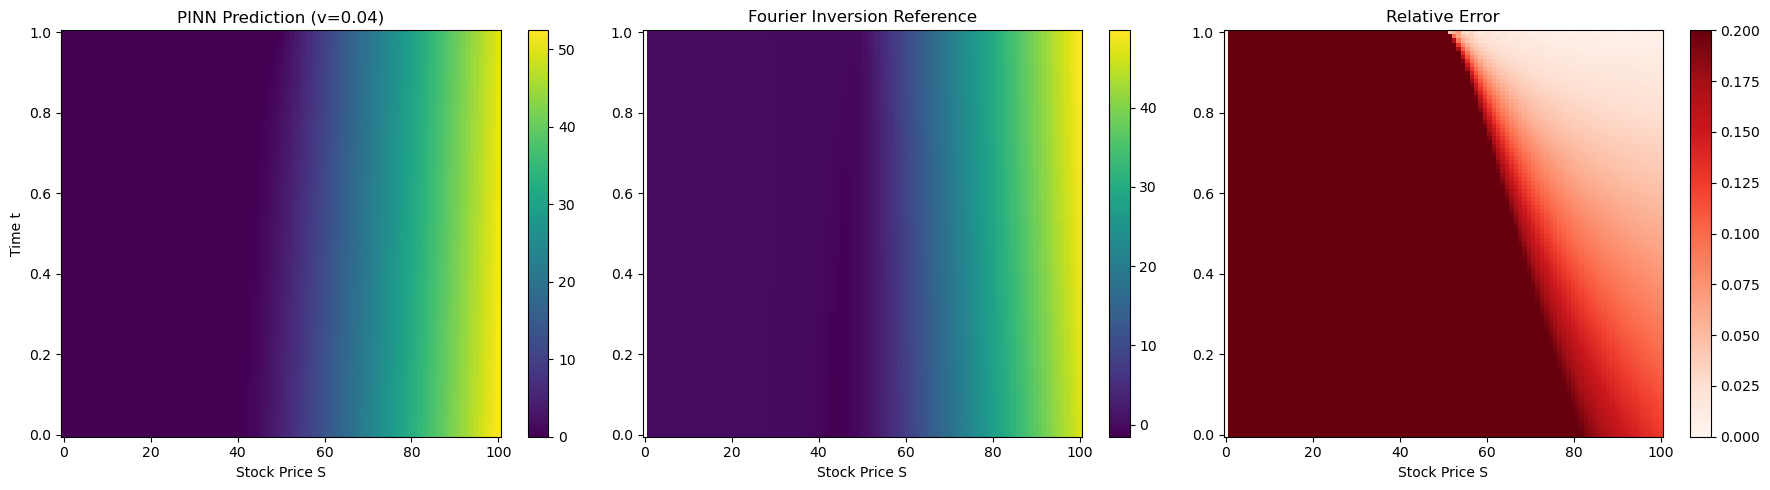

Maximum relative error: 48058952807.46%


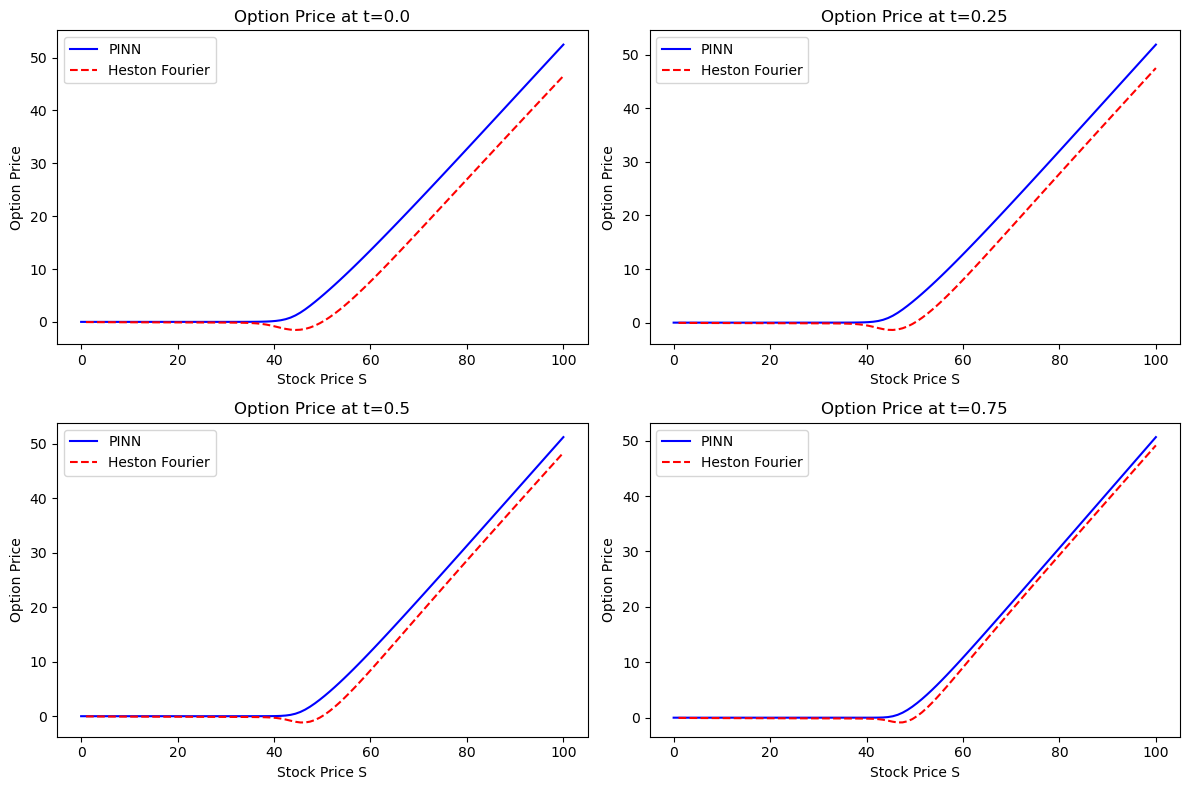

In [26]:
# 主程序参数设置
if __name__ == "__main__":
    # Heston模型参数
    r = 0.05        # 无风险利率
    kappa = 2.0     # 波动率均回复速度
    theta = 0.05    # 长期波动率均值
    vola_sigma = 0.5 # 波动率的波动率
    rho = -0.8      # S和v的相关系数

    T = 1.0         # 到期时间
    K = 50          # 执行价
    v0 = 0.1     # 初始波动率

    # 计算域设置
    S_min, S_max = 0.0, 100.0
    v_min, v_max = 0.01, 0.3
    t_min, t_max = 0.0, T

    # 训练数据生成
    N_u = 2000      # 边界条件点数
    N_f = 10000     # 域内采样点数

    # 初始条件（到期日）
    S_0 = np.linspace(S_min, S_max, N_u//2)[:, None]
    v_0 = np.random.uniform(v_min, v_max, (N_u//2,1))
    t_0 = T * np.ones((N_u//2, 1))
    X_u_initial = np.hstack([S_0, v_0, t_0])
    u_0 = np.maximum(S_0 - K, 0)

    # 边界条件：S=0
    S_b = np.zeros((N_u//4,1))
    v_b = np.random.uniform(v_min, v_max, (N_u//4,1))
    t_b = np.random.uniform(t_min, T, (N_u//4,1))
    X_b_S0 = np.hstack([S_b, v_b, t_b])
    u_b_S0 = np.zeros_like(S_b)

    # 边界条件：v=0
    v_b = np.zeros((N_u//4,1))
    S_b = np.random.uniform(S_min, S_max, (N_u//4,1))
    t_b = np.random.uniform(t_min, T, (N_u//4,1))
    X_b_v0 = np.hstack([S_b, v_b, t_b])
    u_b_v0 = np.maximum(S_b - K*np.exp(-r*(T - t_b)), 0)  # BS解析解

    # 合并所有边界条件
    X_u_train = np.vstack([X_u_initial, X_b_S0, X_b_v0])
    u_train = np.vstack([u_0, u_b_S0, u_b_v0])

    # 随机采样点（Latin Hypercube Sampling）
    X_f_train = lhs(3, N_f)
    X_f_train[:,0] = S_min + (S_max - S_min)*X_f_train[:,0]
    X_f_train[:,1] = v_min + (v_max - v_min)*X_f_train[:,1]
    X_f_train[:,2] = t_min + (t_max - t_min)*X_f_train[:,2]

    # 神经网络结构
    layers = [3, 40, 40, 40, 40, 40, 1]

    # 初始化模型
    model = PhysicsInformedNN(
        X_u_train, u_train, X_f_train, layers, 
        [S_min, v_min, t_min], [S_max, v_max, T],
        r=r, kappa=kappa, theta=theta, 
        vola_sigma=vola_sigma, rho=rho
    )

    # 训练模型
    print("Training PINN model...")
    start_time = time.time()
    model.train()
    elapsed = time.time() - start_time
    print(f"Training completed in {elapsed:.2f} seconds")

    # 验证与可视化
    v_fixed = 0.04
    S_test = np.linspace(S_min, S_max, 100)[:, None]
    t_test = np.linspace(0, T, 100)[:, None]
    S_grid, t_grid = np.meshgrid(S_test, t_test)
    X_test = np.hstack([S_grid.ravel()[:,None], 
                       v_fixed*np.ones_like(S_grid.ravel()[:,None]),
                       t_grid.ravel()[:,None]])

    # 获取预测值
    u_pred, _ = model.predict(X_test)
    u_pred = u_pred.reshape(S_grid.shape)

    # 计算Heston傅里叶解
    def compute_Heston(S, t):
        return heston_price(S, K, T-t, r, v_fixed, kappa, theta, vola_sigma, rho)
    
    U_exact = np.zeros_like(S_grid)
    for i in range(S_grid.shape[0]):
        for j in range(S_grid.shape[1]):
            U_exact[i,j] = compute_Heston(S_grid[i,j], t_grid[i,j])

    # 计算相对误差
    error = np.abs(U_exact - u_pred)/np.maximum(U_exact, 1e-8)
    error = np.nan_to_num(error)
    
    # 绘制结果
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    im0 = axes[0].pcolormesh(S_grid, t_grid, u_pred, shading='auto', cmap='viridis')
    axes[0].set_title('PINN Prediction (v=0.04)')
    axes[0].set_xlabel('Stock Price S')
    axes[0].set_ylabel('Time t')
    fig.colorbar(im0, ax=axes[0])

    im1 = axes[1].pcolormesh(S_grid, t_grid, U_exact, shading='auto', cmap='viridis')
    axes[1].set_title('Fourier Inversion Reference')
    axes[1].set_xlabel('Stock Price S')
    fig.colorbar(im1, ax=axes[1])

    im2 = axes[2].pcolormesh(S_grid, t_grid, error, shading='auto', cmap='Reds', vmin=0, vmax=0.2)
    axes[2].set_title('Relative Error')
    axes[2].set_xlabel('Stock Price S')
    fig.colorbar(im2, ax=axes[2])

    plt.tight_layout()
    plt.show()

    print(f"Maximum relative error: {np.max(error):.2%}")

    # 比较不同时间点的曲线
    t_values = [0.0, 0.25, 0.5, 0.75]
    S_plot = np.linspace(S_min, S_max, 100)[:, None]
    
    plt.figure(figsize=(12, 8))
    for i, t_val in enumerate(t_values):
        X_plot = np.hstack([S_plot, v_fixed * np.ones_like(S_plot), t_val * np.ones_like(S_plot)])
        u_pred_plot, _ = model.predict(X_plot)
        u_exact_plot = np.array([compute_Heston(S, t_val) for S in S_plot.ravel()])
        
        plt.subplot(2, 2, i+1)
        plt.plot(S_plot, u_pred_plot, 'b-', label='PINN')
        plt.plot(S_plot, u_exact_plot, 'r--', label='Heston Fourier')
        plt.title(f'Option Price at t={t_val}')
        plt.xlabel('Stock Price S')
        plt.ylabel('Option Price')
        plt.legend()
    
    plt.tight_layout()
    plt.show()
